In [1]:
# 2023 Gabriel J. Diaz @ RIT

import os
import sys
import numpy as np
import av
import logging
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pathlib import Path, PurePath


logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [2]:
def get_timing_info(file_path):

    container_in = av.open(file_path, mode="r", timeout = None)
    time_base_out = container_in.streams.video[0].time_base
    num_frames = container_in.streams.video[0].frames
    average_fps = container_in.streams.video[0].average_rate
    
#     container_out = av.open(out_video_path, mode="w", timeout = None)
#     stream = container_out.add_stream("libx264", framerate = average_fps)
#     stream.options["crf"] = "20"
#     stream.pix_fmt = container_in.streams.video[0].pix_fmt
#     stream.time_base = container_in.streams.video[0].time_base

    packet_pts_out = []
    pts_out = []
    dts_out = []
    frame_time_base_out = []
    relative_time_out = []
    
    count = 0
    
    #for raw_frame in container_in.decode(video=0):
    for raw_frame in tqdm(container_in.decode(video=0), desc="Working.", unit= 'frames',total = num_frames):
            
        pts_out.append(raw_frame.pts)
        dts_out.append(raw_frame.dts)
        frame_time_base_out.append(raw_frame.time_base)
        relative_time_out.append( np.float32(raw_frame.pts * raw_frame.time_base) )
        
#         for packet in stream.encode(raw_frame):
#             packet_pts_out.append((raw_frame.pts, packet.pts))
#             container_out.mux(packet)
        
        count = count+1
        
    
#     for packet in stream.encode(raw_frame):
#         container_out.mux(packet)
                
    print('Time base ' + str( container_in.streams.video[0].time_base))
    print('Num frames ' + str(container_in.streams.video[0].frames))
    print('Avg rate ' + str(container_in.streams.video[0].average_rate))
    print('Start time ' + str(container_in.start_time))
    print('Duration ' + str(container_in.duration))

    container_in.close()
#     container_out.close()
    return time_base_out, pts_out, dts_out, packet_pts_out


In [3]:
    
# file_path = Path('D:\\Github\\retinal_flow_toolkit\\videos\\Yoyo-LVRA.mp4')

# file_path = Path('D:\\Github\\retinal_flow_toolkit\\sandbox\\testVid.mp4')

hsv_video_path = r'D:\Data\Driving_1\Aware-AI\CM\S001\PupilData\000\exports\000\world_nvidia2_hsv_overlay.mp4'
world_video_path = r'D:\Data\Driving_1\Aware-AI\CM\S001\PupilData\000\world.mp4'
out_video_path = r'D:\Data\Driving_1\Aware-AI\CM\S001\PupilData\000\pts_corrected_hsv_overlay.mp4'



## Compare original and copy pts 

In [4]:
# time_base_orig, pts_orig, dts_orig, packet_pts_out_orig = get_timing_info(world_video_path)

# time_base_copy, pts_copy, dts_copy, packet_pts_out_copy = get_timing_info(hsv_video_path)

# plt.rc('xtick', labelsize=20) 
# plt.rc('ytick', labelsize=20) 

# # dts_a = np.array(dts_a,dtype=np.float32)
# # dts_b = np.array(dts_b,dtype=np.float32)

# fig, ax = plt.subplots(figsize=(15, 10))

# plt.subplot(2,1,1)

# plt.scatter(np.arange(0,len(pts_orig)) ,np.array(pts_orig) * float(time_base_orig),fc='r',s=20)
# plt.scatter(np.arange(0,len(pts_copy)) ,np.array(pts_copy) * float(time_base_copy),fc='b',s=2)

# plt.ylabel('time')
# plt.xlabel('pts * time_base')
# plt.legend(['original','transcoded copy'])

# plt.subplot(2,1,2)

# plt.scatter(np.arange(0,len(dts_orig)) ,np.array(dts_orig) * float(time_base_orig),fc='r',s=20)
# plt.scatter(np.arange(0,len(dts_copy)) ,np.array(dts_copy) * float(time_base_copy),fc='b',s=2)

# # plt.plot(np.arange(0,len(dts_c)) ,np.array(dts_c) * float(time_base_c),':g')

# plt.ylabel('time')
# plt.xlabel('dts * time_base')
# plt.legend(['original','transcoded'])

# plt.savefig( 'frame_timings.png')

# plt.rcParams.update({'font.size': 22})

# print(time_base_orig)
# print(time_base_copy)


## Combine pts from original video with content from a second video into an output video

In [5]:
pts_video_source = world_video_path
pts_video_destination = hsv_video_path
output_video_desination = out_video_path

container_in = av.open(pts_video_source)
average_fps = container_in.streams.video[0].average_rate
num_frames_in = container_in.streams.video[0].frames
time_base_in = container_in.streams.video[0].time_base
encoded_frame_count_in = container_in.streams.video[0].encoded_frame_count

# container_in.sort_dts = True
# container_in.flush_packets = True
# container_in.streams.video[0].codec_context.skip_frame = "NONKEY"



In [6]:
video_content_source = pts_video_destination

container_copy = av.open(video_content_source)
average_fps = container_copy.streams.video[0].average_rate
num_frames_copy = container_copy.streams.video[0].frames
time_base_copy = container_copy.streams.video[0].time_base
encoded_frame_count = container_copy.streams.video[0].encoded_frame_count

print(num_frames_copy)
print(time_base_copy)

14428
1/29852


In [7]:
container_out = av.open(output_video_desination, mode="w", timeout = None)

stream_out = container_out.add_stream("libx264", framerate = average_fps)
stream_out.options["crf"] = "10"
stream_out.pix_fmt = container_in.streams.video[0].pix_fmt
stream_out.time_base = container_in.streams.video[0].time_base


In [8]:
# idx = 0

# for raw_frame in tqdm(container_in.decode(video=0), desc="Working.", unit= 'frames',total = num_frames_in):

# #     raw_frame.pts = pts[idx]
# #     raw_frame.time_base = pts[idx]
#     # raw_frame.dts = dts[idx]
    
    
#     for packet in stream_out.encode(raw_frame):
#         packet.stream = stream_out
#         packet.time_base = time_base_orig
#         packet.pts = pts_orig[idx]
#         container_out.mux(packet)

#     idx = idx + 1

# # # Flush stream
# for packet in stream_out.encode():

#     packet.stream = stream_out
#     packet.time_base = time_base_in
#     packet.pts = pts_orig[idx]
#     container_out.mux(packet)


# container_in.close()
# container_out.close()

In [10]:
# Iterate over the frames in the input videos
# for packet1 in container_in.demux(container_in.streams.video[0]):
    
for packet1 in tqdm(container_in.demux(video=0), desc="Working.", unit= 'frames',total = num_frames_in):    
    for frame1 in packet1.decode():
#         try:
        packet2 = next(container_copy.demux(container_copy.streams.video[0]))
        #packet2 = next(container_copy.demux(container_copy.streams.video[0]))
        
        for frame2 in packet2.decode():
            
            #frame2 = packet2.decode()[0]

            # Copy the pts from the frame in the first video to the frame in the second video
            frame2.pts = frame1.pts
            frame2.time_base = frame1.time_base

            # Write the frame to the output video
            packets = stream_out.encode(frame2)
            if packets is not None:
                for packet in packets:
#                     packet.dts = frame1.dts
                    packet.pts = frame1.pts
                    container_out.mux(packet)

#         except StopIteration:
#             break


Working.: 100%|██████████████████████████████████████████████████████████████| 14428/14428 [02:27<00:00, 97.56frames/s]


In [13]:
print(container_in.streams.video[0].frames)

print(stream_out.frames)

14428
14427


In [12]:

# Flush any remaining frames
for packet in stream_out.encode():
#     packet.dts = frame1.dts
    packet.pts = frame1.pts
    container_out.mux(packet)


In [14]:

# Close all the containers
container_in.close()
container_copy.close()
container_out.close()

In [15]:
time_base_orig, pts_orig, dts_orig, packet_pts_out_orig = get_timing_info(world_video_path)

time_base_copy, pts_copy, dts_copy, packet_pts_out_copy = get_timing_info(output_video_desination)

Working.: 100%|████████████████████████████████████████████████████████████| 14428/14428 [00:10<00:00, 1417.93frames/s]


Time base 1/65535
Num frames 14428
Avg rate 945538980/31674017
Start time 20005
Duration 483315000


Working.: 100%|█████████████████████████████████████████████████████████████| 14427/14427 [00:20<00:00, 713.42frames/s]

Time base 1/65535
Num frames 14427
Avg rate 945473445/31674422
Start time 1431006
Duration 483377000


In [16]:
# np.array(dts_copy) 

C:\Users\gabri\AppData\Local\Temp\ipykernel_108384\1687518610.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,1)


1/65535
1/65535


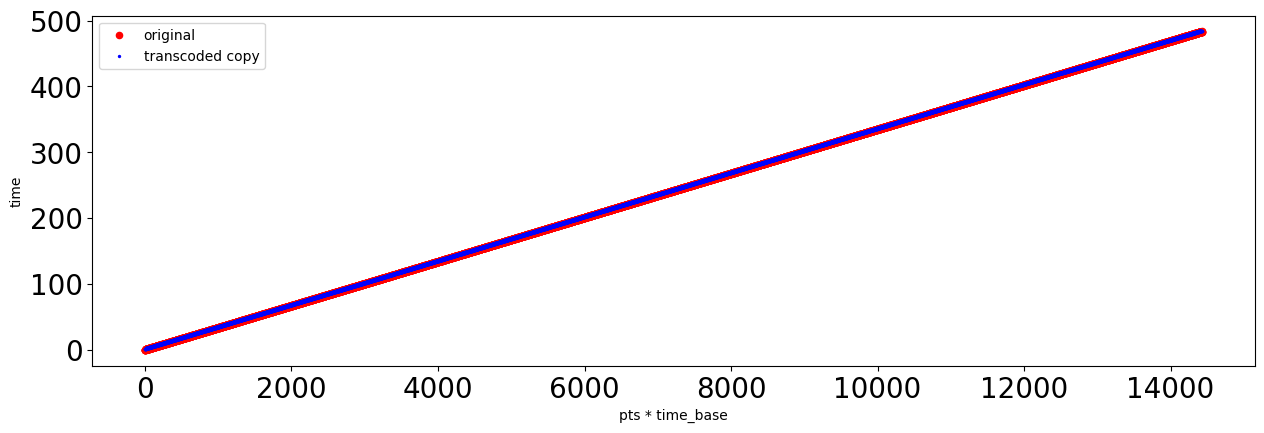

In [17]:
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

# dts_a = np.array(dts_a,dtype=np.float32)
# dts_b = np.array(dts_b,dtype=np.float32)

fig, ax = plt.subplots(figsize=(15, 10))

plt.subplot(2,1,1)

plt.scatter(np.arange(0,len(pts_orig)) ,np.array(pts_orig) * float(time_base_orig),fc='r',s=20)
plt.scatter(np.arange(0,len(pts_copy)) ,np.array(pts_copy) * float(time_base_copy),fc='b',s=2)

plt.ylabel('time')
plt.xlabel('pts * time_base')
plt.legend(['original','transcoded copy'])

plt.savefig( 'frame_timings.png')

plt.rcParams.update({'font.size': 22})

print(time_base_orig)
print(time_base_copy)


In [18]:
np.array(pts_orig)[:20] 

array([ 1311,  4108,  6375,  8557, 10736, 12938, 15183, 17456, 19098,
       21491, 23130, 26018, 28169, 30400, 32539, 34714, 36941, 39246,
       41262, 43450])

In [19]:
np.array(pts_copy)[:20]

array([ 93781,  95971,  98145, 100337, 102543, 104201, 106882, 109064,
       111247, 113436, 115618, 117802, 119977, 122205, 124352, 126533,
       128743, 130370, 133084, 135282])

In [20]:
def crop_image(bgr_image,win_size):
    
    # crops off the bad OF estimation from the outer parts of the image
    h = np.shape(bgr_image)[0]
    w = np.shape(bgr_image)[1]

    # width of analysis window in proportions of image width/height

    b = int(h/2 + (win_size*h)/2)
    t = int(h/2 - (win_size*h)/2)
    l = int(w/2 - (win_size*w)/2)
    r = int(w/2 + (win_size*w)/2)

    sm_image = bgr_image[t:b,l:r,:]

    return sm_image

    
def bgr_flow_frame_to_vector_flow(bgr_frame):
    
    hsv = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2HSV)
    
    mag = hsv[...,2]
    angle = (hsv[..., 0] * np.pi * 2.0) / 180.0 # angles are in radians here
    
    u = np.cos(angle) * mag * -1 # this is the same as flow[...,0] * mag * -1, as I did above
    v = np.sin(angle) * mag
    
#     mag = np.array(mag).astype(np.float64)
#     angle = np.array(angle).astype(np.float64)    
#     u, v = cv2.polarToCart(mag, angle, angleInDegrees = True)
    
     
    flow = np.zeros([np.shape(bgr_frame)[0],np.shape(bgr_frame)[1],2])

    flow[...,0] = u
    flow[...,1] = v
    
    return flow


def plot_flow_overlay(image_in, flow_in, crop_to=0.8, skippts=5,scale=None, scale_units = 'width',width=.008, return_image = False):
    
    dpi = 100
    fig, ax = plt.subplots()
    #plt.subplots(figsize=(np.shape(image_in)[1] / dpi, np.shape(image_in)[0] / dpi))
    canvas = FigureCanvas(fig)
    ax.margins(0)

    if crop_to:
        image_in = crop_image(image_in,crop_to)
        flow_in = crop_image(flow_in,crop_to)
    
    s = slice(None,None,skippts)
    
    xmax=np.shape(image_in)[1]
    xpoints = int(np.shape(image_in)[1])
    x=np.linspace(0,np.shape(image_in)[1],xmax)

    ymax=np.shape(image_in)[0]
    ypoints = int(np.shape(image_in)[0])
    y=np.linspace(0,np.shape(image_in)[0],ymax)

    x = x[s]
    y = y[s]
    x2d,y2d=np.meshgrid(x,y,indexing='xy')

    u = flow_in[...,0]
    v = flow_in[...,1]
    u = (u[s,s]/255) * 20
    v = (v[s,s]/255) * 20

    mag = np.sqrt(u**2 + v**2)
    xs, ys = np.where( mag > np.median(mag) )

    plt.imshow(cv2.cvtColor(image_in, cv2.COLOR_BGR2RGB))
    ax.axis('off') 
    
    plt.quiver(x2d[xs,ys],y2d[xs,ys],u[xs,ys],v[xs,ys],color='white', alpha=0.7, width=width,scale = scale,
                  scale_units = 'inches')

    
    if return_image:
        
        canvas.draw()  # draw the canvas, cache the renderer
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,)) 
        return image_from_plot
    

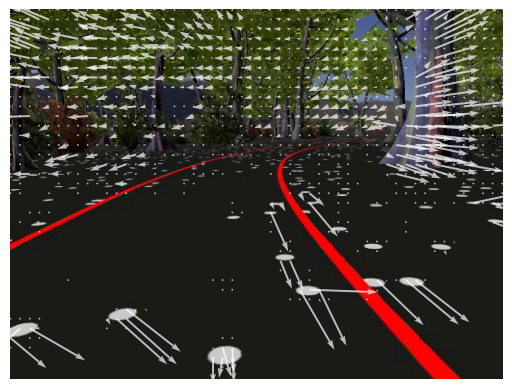

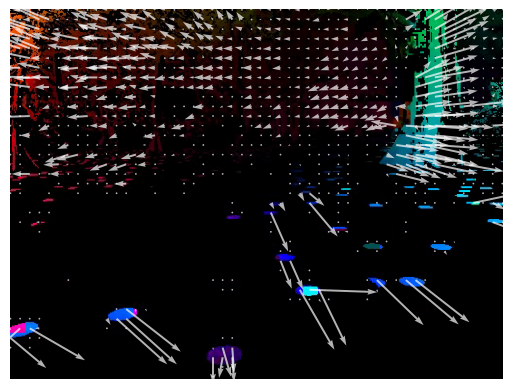

In [32]:
os.add_dll_directory("D://opencvgpu//opencv_build_310//bin")
os.add_dll_directory("C://Program Files//NVIDIA GPU Computing Toolkit//CUDA//v11.8//bin")
import cv2

world_video = cv2.VideoCapture(world_video_path)
copy_video = cv2.VideoCapture(out_video_path)

w_f = 4002
f_f = 4000


plt.rcParams['figure.figsize'] = [640/100., 480 /100.]

world_video.set(cv2.CAP_PROP_POS_FRAMES, w_f)
world_success, bgr_world = world_video.read()

copy_video.set(cv2.CAP_PROP_POS_FRAMES, f_f)
flow_success, bgr_flow = copy_video.read()
flow = bgr_flow_frame_to_vector_flow( bgr_flow)

plot_flow_overlay(bgr_world, flow, crop_to=0.8, skippts=10,scale=None, scale_units = 'width',width=.004)

####
copy_video.set(cv2.CAP_PROP_POS_FRAMES, f_f)
flow_success, bgr_flow = copy_video.read()
flow = bgr_flow_frame_to_vector_flow( bgr_flow)
plot_flow_overlay(bgr_flow, flow, crop_to=0.8, skippts=10,scale=None, scale_units = 'width',width=.004)
